In [ ]:
!pip install heartpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.8 MB/s 


In [ ]:
!pip install neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [ ]:
''' code to read ecg reading from arduino 
import csv
import serial # Module needed for serial communication
#code to read data from the arduino
ser = serial.Serial('/dev/ttyUSB0', 9600, timeout=1)
ser.flush()
ecg=[]
while(len(ecg)<5000):
  if(ser.in_waiting > 0):
    # Convert the data from a byte into a string of type 'utf-8'
    line = ser.readline().decode('utf-8').rstrip()
    #converting the data from string to int
    line_int=int(line)
    #if line_int<-10:
    # pass
    col=[]
    col.append(line_int)
    ecg.append(col)

print(ecg)
#code to put the ecg data into csv file. for not just one column is enough
#file=open('eval.csv','a+',newline='')
file=open('ECG.csv','a+',newline='')
write=csv.writer(file)
write.writerows("h")
write.writerows(ecg)
file.close
'''

In [ ]:
Code running on arduino to collect data and send it to Rpi
int high_val=700;
void setup(){
  // Set the baud rate  
  Serial.begin(9600);
  pinMode(10, INPUT); // Setup for leads off detection LO +
  pinMode(11, INPUT); // Setup for leads off detection LO -
   
}
 
void loop(){
  
  if((digitalRead(10) == 1)||(digitalRead(11) == 1)){
  Serial.println(high_val);
  }
  else{
  // send the value of analog input 0:
  Serial.println(analogRead(A0));
  }
  delay(1);
}

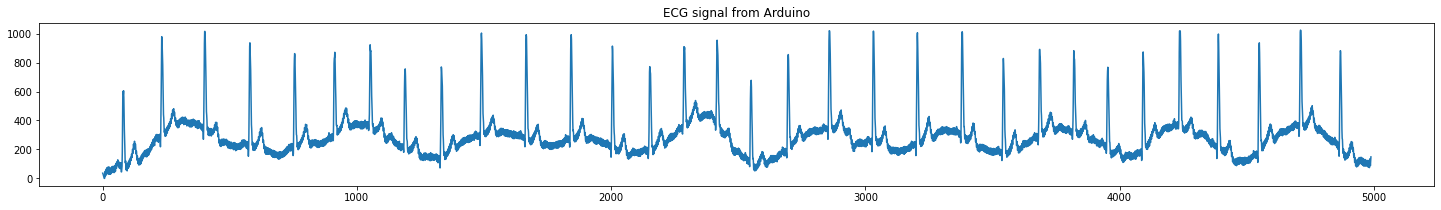

Numerator coefficients of high pass filter   [ 0.94998178 -3.79992713  5.6998907  -3.79992713  0.94998178]  Denominator coefficients of high pass filters are  [ 1.         -3.89738598  5.69739    -3.70246715  0.90246539]


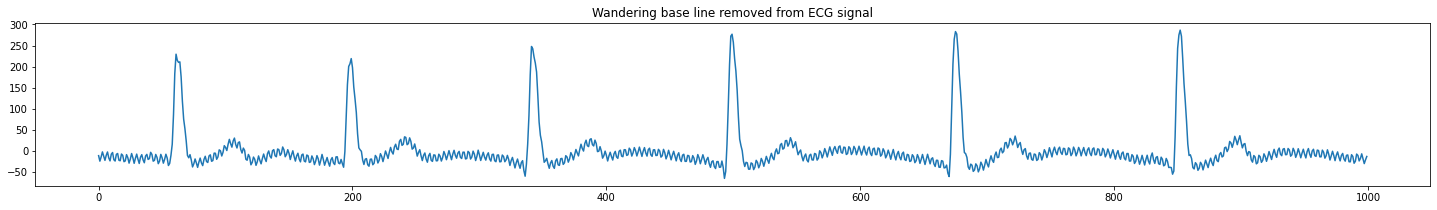

Numerator coefficients of LOW pass filter   [0.02118568 0.08474273 0.1271141  0.08474273 0.02118568]  Denominator coefficients of low pass filters are  [ 1.         -1.47133907  1.17804541 -0.43554871  0.0678133 ]


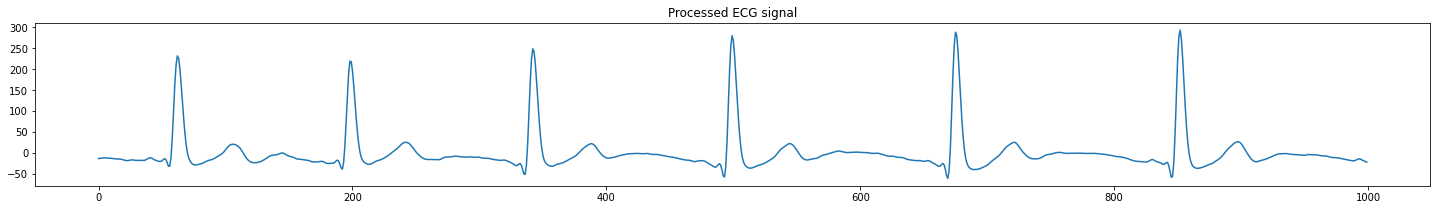

Slopes obtained using formula =  [0.2452477  0.19830768 0.17944603 0.23381315 0.21091395 0.20007977
 0.17100005 0.18696656 0.17907661 0.19486838 0.21654041 0.21057328
 0.24281082 0.19480789 0.18050972 0.14858213 0.16680103 0.15818027
 0.23225104 0.22005703 0.2381933  0.23083638 0.22688075 0.19304215
 0.15553912 0.14437222 0.16054441 0.19383145 0.18048518 0.17438015
 0.23307587 0.22317471]
number of slopes in ecg =  32


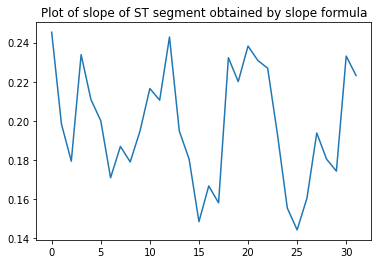

mean slope using formula =  0.19766216230330091
mean slope using differentiation =  0.20175104504029476


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


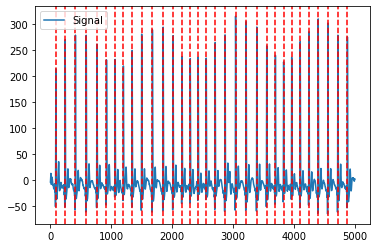

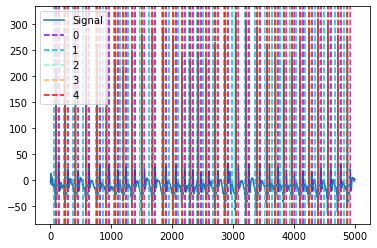

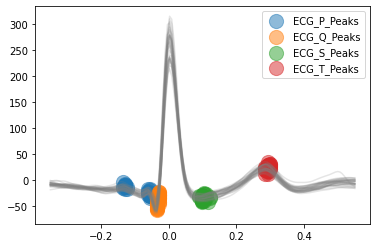

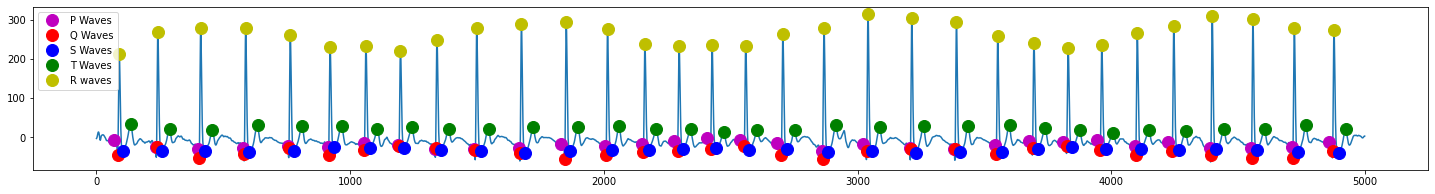

number_of_ecg_r_peaks    32
THE SAMPLE WAS COLLECTED FOR 30 SECONDS. TO FIND THE HEART RATE NUMBER OF R PEAKSx2 =  64
No T wave inversion detected
Enter Patient ID : 213
Enter age : 21
average_heart_rate =  64


In [ ]:
import heartpy as hp
import neurokit2 as nk
import csv
import math
import pandas as pd
import numpy as np
from numpy import diff
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.signal as signal

sample_rate=176 #this is the rate at which the data is recieved in from the arduino to Rpi
ecg = hp.get_data('ECG.csv')
plt.figure(figsize=(25,3))
plt.title('ECG signal from Arduino')
plt.plot(hp.scale_data(ecg[10:5000]))
plt.show()

dataset = pd.read_csv("ECG.csv") # passing throught high pass filter to remove wandering base line
y = [e for e in dataset.h]
N = len(y)
Fs = 160
Fcl=2
WnL=Fcl/Fs
T = 1.0 / Fs
x = np.linspace(0.0, N*T, N)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
b, a = signal.butter(4,WnL,'highpass')
tempf = signal.filtfilt(b,a, y)
print("Numerator coefficients of high pass filter  ",b," Denominator coefficients of high pass filters are ", a)
yff = scipy.fftpack.fft(tempf)
plt.figure(figsize=(25,3))
plt.title('Wandering base line removed from ECG signal')
plt.plot(tempf[1000:2000])
plt.show()

Fch=50
WnH=Fch/Fs
b, a = signal.butter(4,WnH,'lowpass') # passing it throught the low pass filter to remove the muscle related noise 
tempf2 = signal.filtfilt(b,a, tempf)
print("Numerator coefficients of LOW pass filter  ",b," Denominator coefficients of low pass filters are ", a)
yff2 = scipy.fftpack.fft(tempf2)
plt.figure(figsize=(25,3))
plt.title('Processed ECG signal')
plt.plot(tempf2[1000:2000])
plt.show()

ecg_sig=tempf2

rpeaks = nk.ecg_peaks(ecg_sig, sampling_rate=Fs) #this function returns the count of ECG where the r peaks are present in ECG signal 
ecg_r_peaks=rpeaks[1]['ECG_R_Peaks']
waves_peak = nk.ecg_delineate(ecg_sig, rpeaks[1]['ECG_R_Peaks'], sampling_rate=176) # returns the count of the P,Q,S and T peaks present in ECG signal
#overlaps all the ECG signals
ecg_t_peaks=waves_peak[1]['ECG_T_Peaks']
ecg_s_peaks=waves_peak[1]['ECG_S_Peaks']

ecg_r_value=[]
for i in ecg_r_peaks:
  ecg_r_value.append(tempf2[i])

ecg_s_value=[]
for i in ecg_s_peaks:
  ecg_s_value.append(tempf2[i])

ecg_t_value=[]
for i in ecg_t_peaks:
  ecg_t_value.append(tempf2[i])

ecg_r_peaks_np = np.array(ecg_r_peaks)
ecg_s_peaks_np = np.array(ecg_s_peaks)
ecg_t_peaks_np = np.array(ecg_t_peaks)
ecg_r_value_np=np.array(ecg_r_value)
ecg_s_value_np=np.array(ecg_s_value)
ecg_t_value_np=np.array(ecg_t_value)
#calculation of slopt using slope formula
slope_formula=(ecg_t_value_np-ecg_s_value_np)/(ecg_t_peaks_np-ecg_s_peaks_np)
slope_formula=slope_formula/10
print("Slopes obtained using formula = ", slope_formula)
print("number of slopes in ecg = ",len(slope_formula))
plt.title('Plot of slope of ST segment obtained by slope formula')
plt.plot(slope_formula)
plt.show()
slope_formula_mean=(np.mean(slope_formula))
print("mean slope using formula = ",slope_formula_mean)


ecg_sig
ecg_s_peaks_np
ecg_t_peaks_np
slope_diff=[]
for i in range(len(ecg_s_peaks_np)):
  y=[]
  x=[]
  for j in range(ecg_s_peaks_np[i],ecg_t_peaks_np[i]):
    y.append(ecg_sig[j])
    x.append(j)
  y=np.array(y)
  x=np.array(x)
  dydx = diff(y)/diff(x)
  slope_diff.append(dydx.mean())

slope_diff=np.array(slope_diff)
slope_diff_mean=(slope_diff.mean())/10
print("mean slope using differentiation = ",slope_diff_mean)

plot = nk.events_plot(rpeaks[1]['ECG_R_Peaks'], ecg_sig)
plot = nk.events_plot([waves_peak[1]['ECG_T_Peaks'],
                       waves_peak[1]['ECG_P_Peaks'],
                       waves_peak[1]['ECG_Q_Peaks'],
                       waves_peak[1]['ECG_S_Peaks'],
                       rpeaks[1]['ECG_R_Peaks']], ecg_sig)

waves_peak = nk.ecg_delineate(ecg_sig, rpeaks[1]['ECG_R_Peaks'], sampling_rate=Fs, method="peak", show=True, show_type='peaks')
plt.show()
t_peak = waves_peak[1]['ECG_T_Peaks']
t_peak = np.array(t_peak)
t_peak = t_peak[~np.isnan(t_peak)]
t_peak = t_peak.astype('int64')

p_peak = waves_peak[1]['ECG_P_Peaks']
p_peak = np.array(p_peak)
p_peak = p_peak[~np.isnan(p_peak)]
p_peak = p_peak.astype('int64')

q_peak = waves_peak[1]['ECG_Q_Peaks']
q_peak = np.array(q_peak)
q_peak = q_peak[~np.isnan(q_peak)]
q_peak = q_peak.astype('int64')

s_peak = waves_peak[1]['ECG_S_Peaks']
s_peak = np.array(s_peak)
s_peak = s_peak[~np.isnan(s_peak)]
s_peak = s_peak.astype('int64')

r_peak=rpeaks[1]['ECG_R_Peaks']
r_peak=np.array(r_peak)
r_peak=r_peak[~np.isnan(r_peak)]
r_peak=r_peak.astype('int64')

plt.figure(figsize=(25,3))
plt.plot(ecg_sig)
plt.plot(p_peak, ecg_sig[p_peak], "om",  markersize=12, label='P Waves')
plt.plot(q_peak, ecg_sig[q_peak], "or",  markersize=12, label='Q Waves')
plt.plot(s_peak, ecg_sig[s_peak], "ob",  markersize=12, label='S Waves')
plt.plot(t_peak, ecg_sig[t_peak], "og",  markersize=12, label='T Waves')
plt.plot(r_peak, ecg_sig[r_peak], "oy",  markersize=12, label='R waves')
plt.legend(loc="upper left")
plt.show()


def get_st_segment(ecg_signal,s_peak, t_peak):
    s_length = len(s_peak)
    t_length = len(t_peak)
    st_array = []
    st_total = 0
    
    if s_length > t_length:
        max_iter = t_length
    else:
        max_iter = s_length
        
    for x in range(0,max_iter):
        start = s_peak[x]
        end = t_peak[x]
        st_value = 0
      
        
        for value in ecg_signal[start:end]:
            st_value = st_value + value

        st_array.append(st_value)
        
    # print(st_array)
    st_array=np.array(st_array)
    st_mean=np.mean(st_array)
    
    return st_mean/1000

def get_q_waves(ecg_signal,q_peak):
    q_wave = []
    q_waves = ecg_signal[q_peak]
    for wave in q_waves:
        q_wave.append(wave)
        
    total_q_wave = sum(q_wave)
        
    if len(q_wave) == 0:
        mean_q_wave = 0
    else:
        mean_q_wave = total_q_wave / len(q_wave)
    
    return mean_q_wave


print('number_of_ecg_r_peaks   ',len(ecg_r_peaks))
print("THE SAMPLE WAS COLLECTED FOR 30 SECONDS. TO FIND THE HEART RATE NUMBER OF R PEAKSx2 = ", len(ecg_r_peaks)*2)


count=0    
mm_value=-0.1
for i in ecg_t_value:
  if i < mm_value:
    count=count+1
if count>1:
  T_inversion=1
  print("T wave inversion detected")
else:
  T_inversion=0
  print("No T wave inversion detected")  

patient_id=str(input("Enter Patient ID : "))
age=int(input("Enter age : "))
average_heart_rate=len(ecg_r_peaks)*2
print("average_heart_rate = ", average_heart_rate)

data=[patient_id,age,slope_diff_mean,T_inversion,average_heart_rate]
header = ['Patient_ID','Age','ST_slope','T_inversion','Average_heart_Rate']
f=open('patient_data.csv','w')
writer=csv.writer(f)
writer.writerow(header)
writer.writerow(data)
f.close()


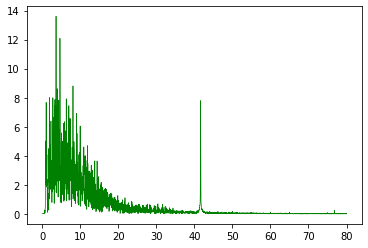

In [ ]:
plt.plot(xf, 2.0/N * np.abs(yff[:N//2]), color='g', linewidth=0.7)

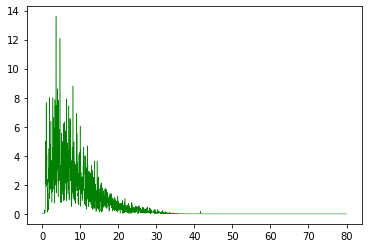

In [ ]:
plt.plot(xf, 2.0/N * np.abs(yff2[:N//2]), color='g', linewidth=0.5)